# Analyse de la Variance (ANOVA)

En statistique, l'**analyse de la variance** (terme souvent abrégé par le terme anglais ANOVA : *Analysis of Variance*) est un ensemble de modèles statistiques utilisés pour vérifier si les moyennes des groupes proviennent d'une même population. Les groupes correspondent aux modalités d'une variable qualitative et les moyennes sont calculés à partir d'une variable continue. Ce test s'applique lorsque l'on mesure une ou plusieurs variables explicatives catégorielle (appelées alors facteurs de variabilité, leurs différentes modalités étant parfois appelées « niveaux ») qui ont de l'influence sur la loi d'une variable continue à expliquer.
```{admonition} Autrement dit
:class: note
L'analyse de la variance permet d'étudier le comportement d'une variable quantitative à expliquer en fonction d'une ou de plusieurs variables qualitatives, aussi appelées nominales catégorielles.
```

La méthode à utiliser pour réaliser des analyses de la variance du paquet `statsmodels` est `anova_lm`, en précisant les modèles statistiques à comparer en paramètres.

Pour examiner l'utilisation de cette méthode, on 

In [2]:
%matplotlib inline
from urllib.request import urlopen
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import pandas as pd
pd.set_option("display.width", 100)
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm

Le jeu de données utilisé constitue un ensemble de $46$ observations des salaires d'un groupe d'employés selon leur expérience, laquelle est une variable numérique variant dans $[0,20]$.

In [4]:
url = "http://stats191.stanford.edu/data/salary.table"
fh = urlopen(url)
salary_table = pd.read_table(fh)
salary_table.to_csv("salary.table")

E = salary_table.E
M = salary_table.M
X = salary_table.X
S = salary_table.S

Text(0, 0.5, 'Salaire')

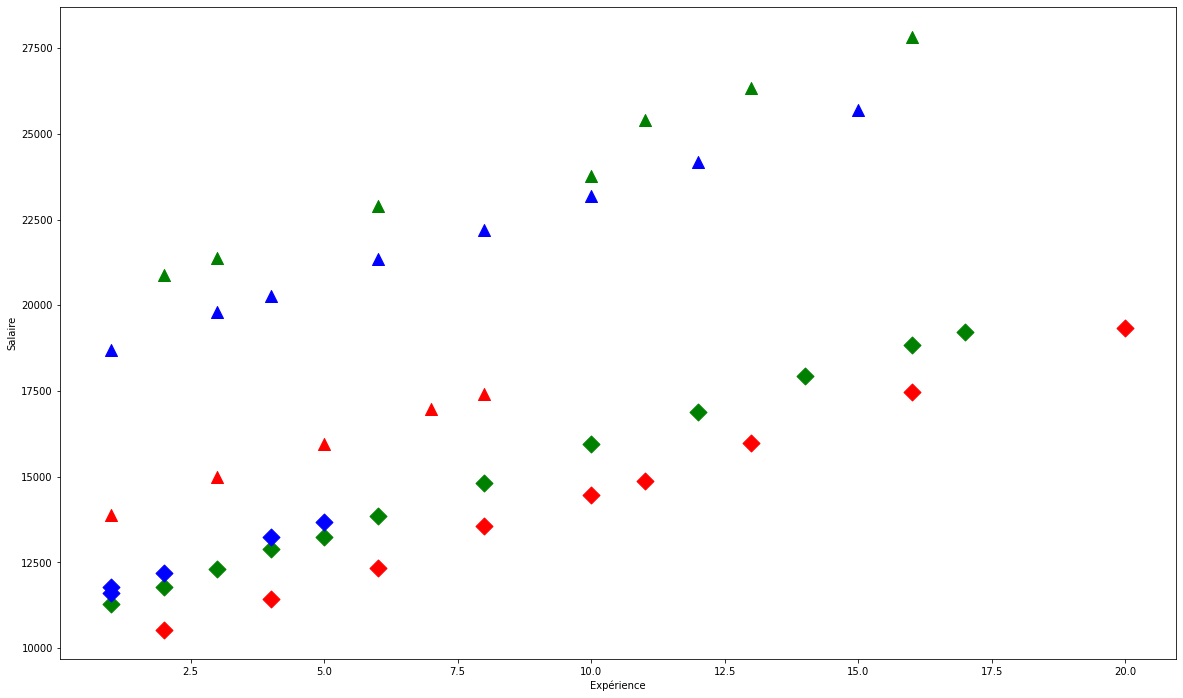

In [6]:
plt.figure(figsize=(20, 12))
symbols = ["D", "^"]
colors = ["r", "g", "blue"]
factor_groups = salary_table.groupby(["E", "M"])
for values, group in factor_groups:
    i, j = values
    plt.scatter(group["X"], group["S"], marker=symbols[j], color=colors[i - 1], s=144)
plt.xlabel("Expérience")
plt.ylabel("Salaire")

On ajuste un modèle linéaire des moindres carrés ordinaires sur les données en question, moyennant la spécification par les formules (type R).

In [7]:
formula = "S ~ C(E) + C(M) + X"
lm = ols(formula, salary_table).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      S   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     226.8
Date:                Thu, 05 Jan 2023   Prob (F-statistic):           2.23e-27
Time:                        21:55:20   Log-Likelihood:                -381.63
No. Observations:                  46   AIC:                             773.3
Df Residuals:                      41   BIC:                             782.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8035.5976    386.689     20.781      0.0

On récupère l'influence sur la régression de chaque observation au travers de la méthode `get_influence()` :

In [8]:
infl = lm.get_influence()
print(infl.summary_table())

       obs      endog     fitted     Cook's   student.   hat diag    dffits   ext.stud.     dffits
                           value          d   residual              internal   residual           
--------------------------------------------------------------------------------------------------
         0  13876.000  15465.313      0.104     -1.683      0.155     -0.722     -1.723     -0.739
         1  11608.000  11577.992      0.000      0.031      0.130      0.012      0.031      0.012
         2  18701.000  18461.523      0.001      0.247      0.109      0.086      0.244      0.085
         3  11283.000  11725.817      0.005     -0.458      0.113     -0.163     -0.453     -0.162
         4  11767.000  11577.992      0.001      0.197      0.130      0.076      0.195      0.075
         5  20872.000  19155.532      0.092      1.787      0.126      0.678      1.838      0.698
         6  11772.000  12272.001      0.006     -0.513      0.101     -0.172     -0.509     -0.170
         7

À présent, on trace le graphique des résidus pour chaque groupe séparément :

Text(0, 0.5, 'Résidus')

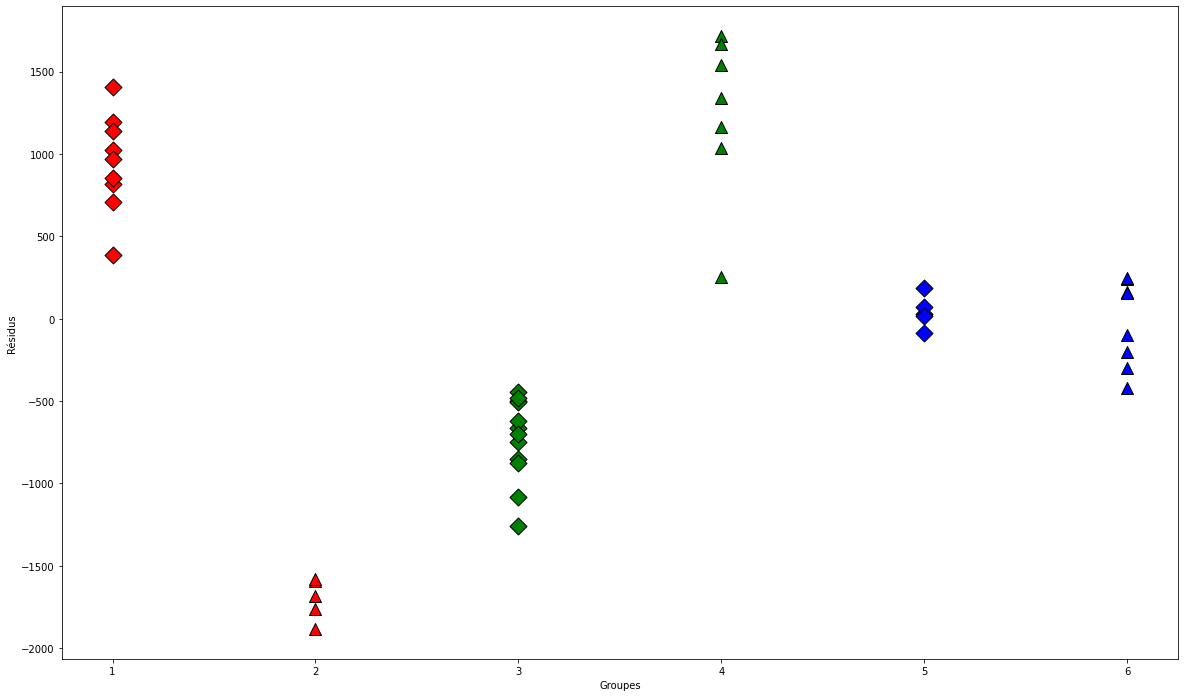

In [9]:
resid = lm.resid
plt.figure(figsize=(20, 12))
for values, group in factor_groups:
    i, j = values
    group_num = i * 2 + j - 1 
    x = [group_num] * len(group)
    plt.scatter(x,resid[group.index],marker=symbols[j],color=colors[i - 1],s=144,edgecolors="black")
plt.xlabel("Groupes")
plt.ylabel("Résidus")

Ensuite, on ajuste un modèle pour le comparer au premier via l'analyse de la variance.

In [10]:
interX_lm = ols("S ~ C(E) * X + C(M)", salary_table).fit()
print(interX_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      S   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     158.6
Date:                Thu, 05 Jan 2023   Prob (F-statistic):           8.23e-26
Time:                        21:59:34   Log-Likelihood:                -379.47
No. Observations:                  46   AIC:                             772.9
Df Residuals:                      39   BIC:                             785.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    7256.2800    549.494     13.205      

À présent, on compare les deux modèles élaborés avec la fonction `anova_lm`

In [11]:
from statsmodels.stats.api import anova_lm

table1 = anova_lm(lm, interX_lm)
print(table1)

interM_lm = ols("S ~ X + C(E)*C(M)", data=salary_table).fit()

table2 = anova_lm(lm, interM_lm)
print(table2)

   df_resid           ssr  df_diff       ss_diff         F    Pr(>F)
0      41.0  4.328072e+07      0.0           NaN       NaN       NaN
1      39.0  3.941068e+07      2.0  3.870040e+06  1.914856  0.160964
   df_resid           ssr  df_diff       ss_diff           F        Pr(>F)
0      41.0  4.328072e+07      0.0           NaN         NaN           NaN
1      39.0  1.178168e+06      2.0  4.210255e+07  696.844466  3.025504e-31


```{admonition} Conclusion
:class: tip
Dès lors que la première valeur du seuil critique ($p$-value) est supérieure à $5\%$, alors le deuxième modèle `interX_lm` est significativement meilleur. Le troisième modèle `interM_lm` ne contribue pas significativement mieux par rapport au modèle de base, dès lors que sa $p$-valeur est inférieure à $5\%$.
```